<a href="https://colab.research.google.com/github/Sidharth1999/Capstone-3/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the notebook for actually creating CNN models for the dataset. We will be using Tensorflow, particularly Keras, to build these models. We will everage Transfer Learning from pre-existing CNN architectures trained on the ImageNet dataset to help build stronger models that recognize important features. This will also help with training times (and therefore give more opportunities to tweak parameters and retrain) since the architecture's weights will be frozen

In [2]:
!pip install tensorflow-gpu
!pip install livelossplot

     |████████████████████████████████| 454.3MB 32kB/s 


In [64]:
#Imports
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import pathlib
import imageio
import functools
import math
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt

To train efficiently in this Colab environment, we should leverage GPUs. This setting can be enabled in the Runtime menu. Let's get information about the GPU allocated to this executing instance.

In [119]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jun 18 20:04:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
projectDir = "/content/drive/My Drive/Springboard-Capstone-3"
dataDir = projectDir + "/" + "data"

In [6]:
#Obtain all 80 categories
categories = []
for file in os.listdir(dataDir): categories.append(file)
print(categories)

['adhirasam', 'aloo_gobi', 'aloo_matar', 'aloo_methi', 'aloo_shimla_mirch', 'aloo_tikki', 'anarsa', 'ariselu', 'bandar_laddu', 'basundi', 'bhatura', 'bhindi_masala', 'biryani', 'boondi', 'butter_chicken', 'chak_hao_kheer', 'cham_cham', 'chana_masala', 'chapati', 'chhena_kheeri', 'chicken_razala', 'chicken_tikka', 'chicken_tikka_masala', 'chikki', 'daal_baati_churma', 'daal_puri', 'dal_makhani', 'dal_tadka', 'dharwad_pedha', 'doodhpak', 'double_ka_meetha', 'dum_aloo', 'gajar_ka_halwa', 'gavvalu', 'ghevar', 'gulab_jamun', 'imarti', 'jalebi', 'kachori', 'kadai_paneer', 'kadhi_pakoda', 'kajjikaya', 'kakinada_khaja', 'kalakand', 'karela_bharta', 'kofta', 'kuzhi_paniyaram', 'lassi', 'ledikeni', 'litti_chokha', 'lyangcha', 'maach_jhol', 'makki_di_roti_sarson_da_saag', 'malapua', 'misi_roti', 'misti_doi', 'modak', 'mysore_pak', 'naan', 'navrattan_korma', 'palak_paneer', 'paneer_butter_masala', 'phirni', 'pithe', 'poha', 'poornalu', 'pootharekulu', 'qubani_ka_meetha', 'rabri', 'ras_malai', 'ras

In [7]:
trainDir = projectDir + "/" + "train"
validationDir = projectDir + "/" + "validation"
testDir = projectDir + "/" + "test"

# **Modeling**

**We are going to try 4 different CNN architectures:**


1.   VGG16
2.   ResNet50
3.   AlexNet
4.   VGG19



While tweaking the parameters of the neural networks, these are potential ones to consider:

**Potential Configurable Parameters:**

1.   Number of layers
2.   Number of nodes per layer
3.   Optimizer
4.   Learning rate of optimizer
5.   Target image size
6.   Generator morphological transformations

In the following cells, you are seeing the parameters for the models that I found led to best test set accuracy, not the initial set of parameters I started with

In [67]:
#Make a directory to save different CNN model features
cnnFeaturesDir = os.path.join(projectDir, 'CNN Architecture Features')

In [ ]:
os.mkdir(cnnFeaturesDir)

## **VGG-16**

In [66]:
input_shape = (240, 240, 3)
learning_rate = 0.001
fine_tune = 2
dropout = 0.2
layer1 = 500
layer2 = 1500

#Build data generators
from tensorflow.keras.applications import vgg16

train_datagen = ImageDataGenerator(
        preprocessing_function = vgg16.preprocess_input,
        rescale=1./255,
        shear_range=0.6,
        zoom_range=0.7,
        horizontal_flip=True,
        vertical_flip=True
        )
test_datagen = ImageDataGenerator(
    preprocessing_function = vgg16.preprocess_input,
    rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        trainDir,
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        validationDir,
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        testDir,
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical')

Found 2560 images belonging to 80 classes.
Found 640 images belonging to 80 classes.
Found 800 images belonging to 80 classes.


### **Compile and train**

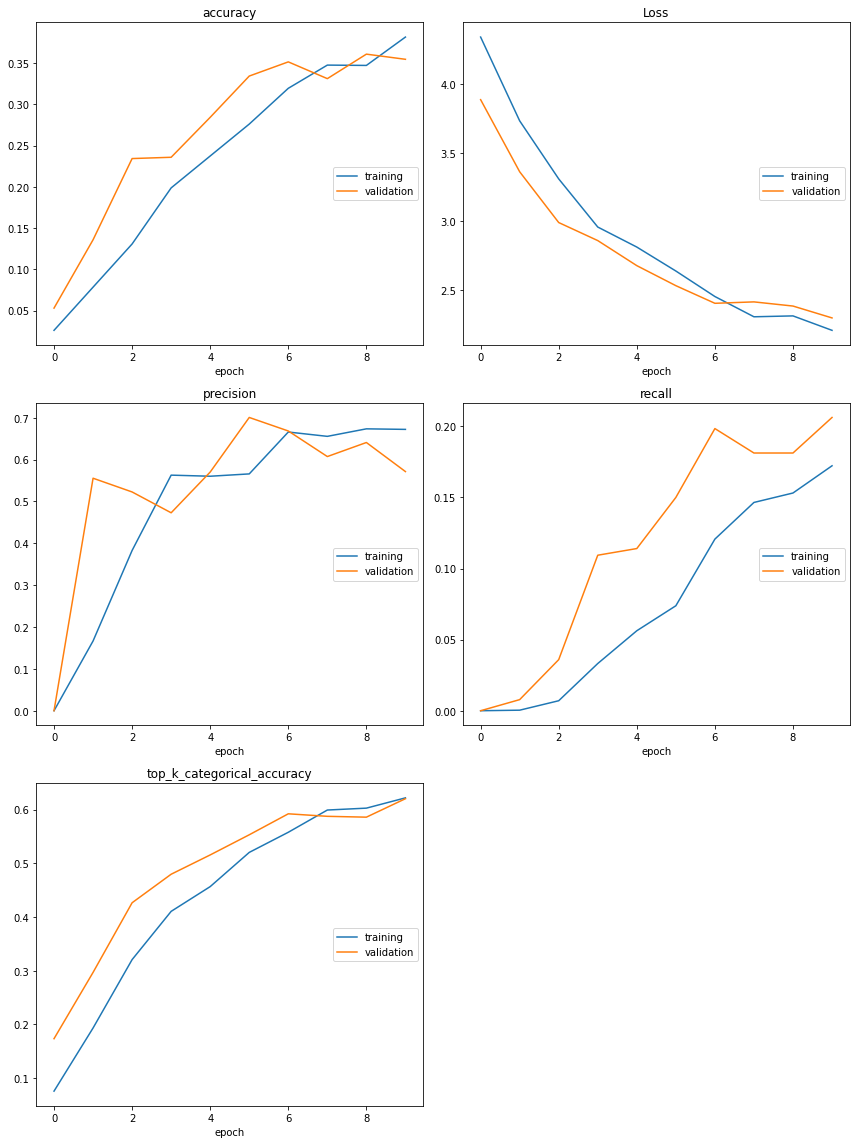

accuracy
	training         	 (min:    0.026, max:    0.382, cur:    0.382)
	validation       	 (min:    0.053, max:    0.361, cur:    0.355)
Loss
	training         	 (min:    2.205, max:    4.346, cur:    2.205)
	validation       	 (min:    2.296, max:    3.889, cur:    2.296)
precision
	training         	 (min:    0.000, max:    0.674, cur:    0.672)
	validation       	 (min:    0.000, max:    0.701, cur:    0.571)
recall
	training         	 (min:    0.000, max:    0.172, cur:    0.172)
	validation       	 (min:    0.000, max:    0.206, cur:    0.206)
top_k_categorical_accuracy
	training         	 (min:    0.076, max:    0.622, cur:    0.622)
	validation       	 (min:    0.173, max:    0.620, cur:    0.620)
Epoch 11/35
31/40 [======================>.......] - ETA: 2:57 - loss: 2.0184 - accuracy: 0.4078 - top_k_categorical_accuracy: 0.6699 - precision: 0.7194 - recall: 0.2132

KeyboardInterrupt: ignored

In [10]:
vggModel = tf.keras.applications.VGG16(input_shape=input_shape,include_top=False,weights='imagenet')

#Make some of the final layers of the base model trainable
if fine_tune > 0:
  for layer in vggModel.layers[:-fine_tune]: layer.trainable = False
else:
  for layer in vggModel.layers: layer.trainable = False

#Build augmented model from base model
inputs = tf.keras.Input(shape=input_shape)
x = vggModel(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten(name="flatten")(x)
x = tf.keras.layers.Dense(layer1, activation='relu')(x)
x = tf.keras.layers.Dense(layer2, activation='relu')(x)
x = tf.keras.layers.Dropout(dropout)(x)
outputs = tf.keras.layers.Dense(80, activation='softmax')(x)

model1 = tf.keras.Model(inputs, outputs)

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
               loss='categorical_crossentropy',
               metrics=['accuracy',
                        tf.keras.metrics.TopKCategoricalAccuracy(k=3),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall()
                        ])

history = model1.fit(
    train_generator,
    epochs=35,
    validation_data=validation_generator,
    steps_per_epoch=int(math.ceil(train_generator.n/train_generator.batch_size)),
    validation_steps=int(math.ceil(validation_generator.n/validation_generator.batch_size)),
    callbacks=[PlotLossesKeras()])

eval_loss, eval_accuracy, acc3, precision, recall = model1.evaluate(validation_generator, verbose=1)
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))
print("k = 3 Accuracy: {:.2f}%".format(acc3 * 100)) 
print("Precision: {}".format(precision)) 
print("Recall: {}".format(recall))

### **Prediction results and performance metrics**

In [12]:
eval_loss, eval_accuracy, acc3, precision, recall = model1.evaluate(test_generator, batch_size=32)
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))
print("k = 3 Accuracy: {:.2f}%".format(acc3 * 100)) 
print("Precision: {}".format(precision)) 
print("Recall: {}".format(recall))

13/13 [==============================] - 362s 30s/step - loss: 2.5445 - accuracy: 0.5038 - top_k_categorical_accuracy: 0.7188 - precision_1: 0.5714 - recall_1: 0.4550
Accuracy: 50.38%
Loss: 2.5444905757904053
k = 3 Accuracy: 71.88%
Precision: 0.5714285969734192
Recall: 0.45500001311302185


### **Save and retrieve model**

In [13]:
model1.save(projectDir + '/' + 'Models/VGG16ModelV9.h5')

In [14]:
model1 = tf.keras.models.load_model(projectDir + '/' + 'Models/VGG16ModelV9.h5')
results = model1.evaluate(test_generator, batch_size=32)
print("test loss, test acc:", results)

13/13 [==============================] - 8s 558ms/step - loss: 2.5445 - accuracy: 0.5038 - top_k_categorical_accuracy: 0.7188 - precision_1: 0.5714 - recall_1: 0.4550
test loss, test acc: [2.544490098953247, 0.5037500262260437, 0.71875, 0.5714285969734192, 0.45500001311302185]


## **ResNet50**

In [15]:
input_shape = (180, 180, 3)
learning_rate = 0.001
fine_tune = 1
dropout = 0.2
layer1 = 200
layer2 = 50

#Build data generators
from tensorflow.keras.applications import resnet

train_datagen = ImageDataGenerator(
        preprocessing_function = resnet.preprocess_input,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(
    preprocessing_function = resnet.preprocess_input,
    rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        trainDir,
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        validationDir,
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        testDir,
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical')

Found 2560 images belonging to 80 classes.
Found 640 images belonging to 80 classes.
Found 800 images belonging to 80 classes.


### **Compile and train**

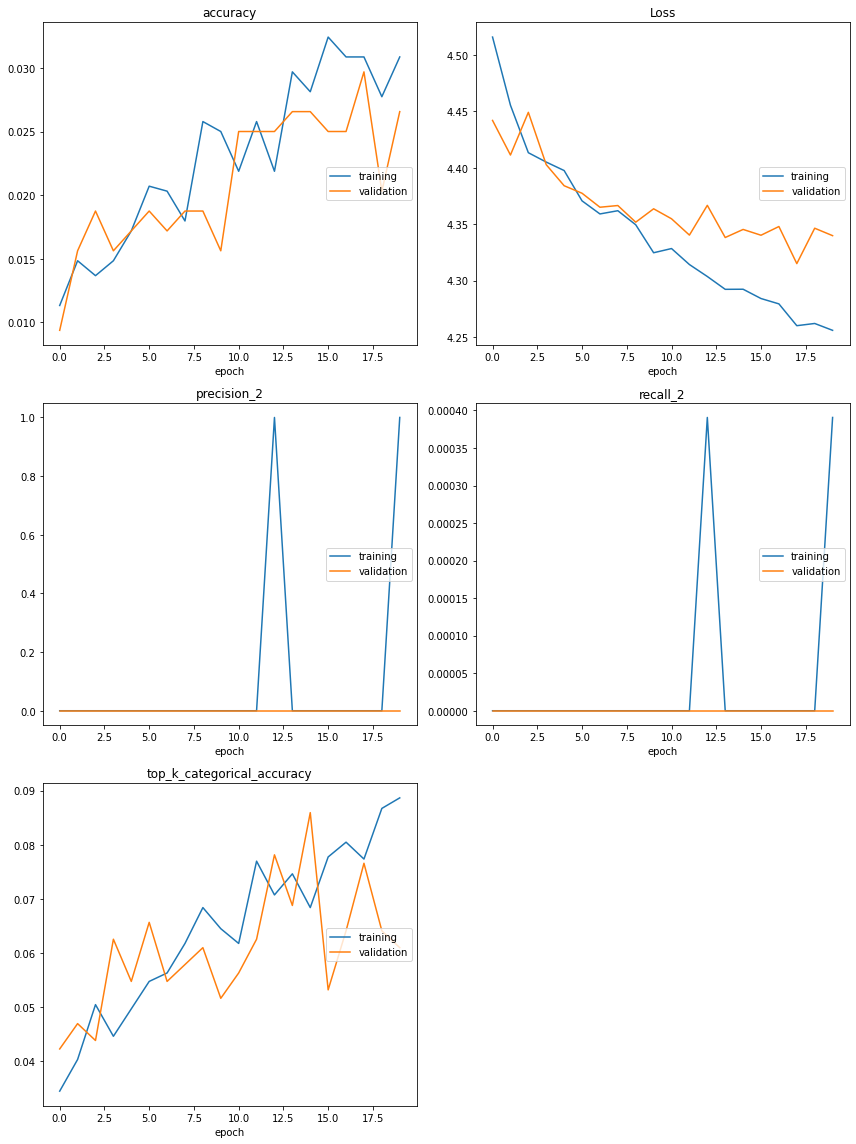

accuracy
	training         	 (min:    0.011, max:    0.032, cur:    0.031)
	validation       	 (min:    0.009, max:    0.030, cur:    0.027)
Loss
	training         	 (min:    4.256, max:    4.516, cur:    4.256)
	validation       	 (min:    4.315, max:    4.449, cur:    4.340)
precision_2
	training         	 (min:    0.000, max:    1.000, cur:    1.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
recall_2
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
top_k_categorical_accuracy
	training         	 (min:    0.034, max:    0.089, cur:    0.089)
	validation       	 (min:    0.042, max:    0.086, cur:    0.061)
10/10 [==============================] - 5s 521ms/step - loss: 4.3399 - accuracy: 0.0266 - top_k_categorical_accuracy: 0.0609 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Accuracy: 2.66%
Loss: 4.339871406555176
k = 3 Accuracy: 6.09%
Precision: 0.0
Recall: 0.0


In [16]:
RN50Model = tf.keras.applications.ResNet50(input_shape=input_shape,include_top=False,weights='imagenet')

if fine_tune > 0:
  for layer in RN50Model.layers[:-fine_tune]: layer.trainable = False
else:
  for layer in RN50Model.layers: layer.trainable = False

inputs = tf.keras.Input(shape=input_shape)
x = RN50Model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(80, activation='softmax')(x)

model2 = tf.keras.Model(inputs, outputs)

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
               loss='categorical_crossentropy',
               metrics=['accuracy',
                        tf.keras.metrics.TopKCategoricalAccuracy(k=3),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall()
                        ])

history = model2.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    steps_per_epoch=int(math.ceil(train_generator.n/train_generator.batch_size)),
    validation_steps=int(math.ceil(validation_generator.n/validation_generator.batch_size)),
    callbacks=[PlotLossesKeras()])

eval_loss, eval_accuracy, acc3, precision, recall = model2.evaluate(validation_generator, verbose=1)
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))
print("k = 3 Accuracy: {:.2f}%".format(acc3 * 100)) 
print("Precision: {}".format(precision)) 
print("Recall: {}".format(recall))

### **Prediction results and performance metrics**

In [17]:
eval_loss, eval_accuracy, acc3, precision, recall = model2.evaluate(test_generator, batch_size=32)
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))
print("k = 3 Accuracy: {:.2f}%".format(acc3 * 100)) 
print("Precision: {}".format(precision)) 
print("Recall: {}".format(recall))

13/13 [==============================] - 7s 526ms/step - loss: 4.3307 - accuracy: 0.0350 - top_k_categorical_accuracy: 0.0725 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Accuracy: 3.50%
Loss: 4.3307085037231445
k = 3 Accuracy: 7.25%
Precision: 0.0
Recall: 0.0


### **Save and retrieve model**

In [18]:
model2.save(projectDir + '/' + 'Models/RNModelV1.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [19]:
model2 = tf.keras.models.load_model(projectDir + '/' + 'Models/RNModelV1.h5')
results = model2.evaluate(test_generator, batch_size=32)
print("test loss, test acc:", results)

13/13 [==============================] - 8s 540ms/step - loss: 4.3307 - accuracy: 0.0350 - top_k_categorical_accuracy: 0.0725 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
test loss, test acc: [4.3307085037231445, 0.03500000014901161, 0.07249999791383743, 0.0, 0.0]


##**AlexNet**

For the 3rd model, we are just going to borrow the bare-bones architecture for AlexNet, not pre-trained weights from ImageNet. AlexNet is not a very large model, so training times should be manageable, and we are somewhat concerned about overfitting on this dataset, so its more reassuring to stick to simpler architectures rather than very deep ones like DenseNet201, etc

In [20]:
input_shape = (180, 180, 3)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.6,
        zoom_range=0.7,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(
    rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        trainDir,
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        validationDir,
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        testDir,
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='categorical')

Found 2560 images belonging to 80 classes.
Found 640 images belonging to 80 classes.
Found 800 images belonging to 80 classes.


### **Compile and train model**

A lot of the code to build the AlexNet architecture was taken from [here](https://analyticsindiamag.com/hands-on-guide-to-implementing-alexnet-with-keras-for-multi-class-image-classification/)

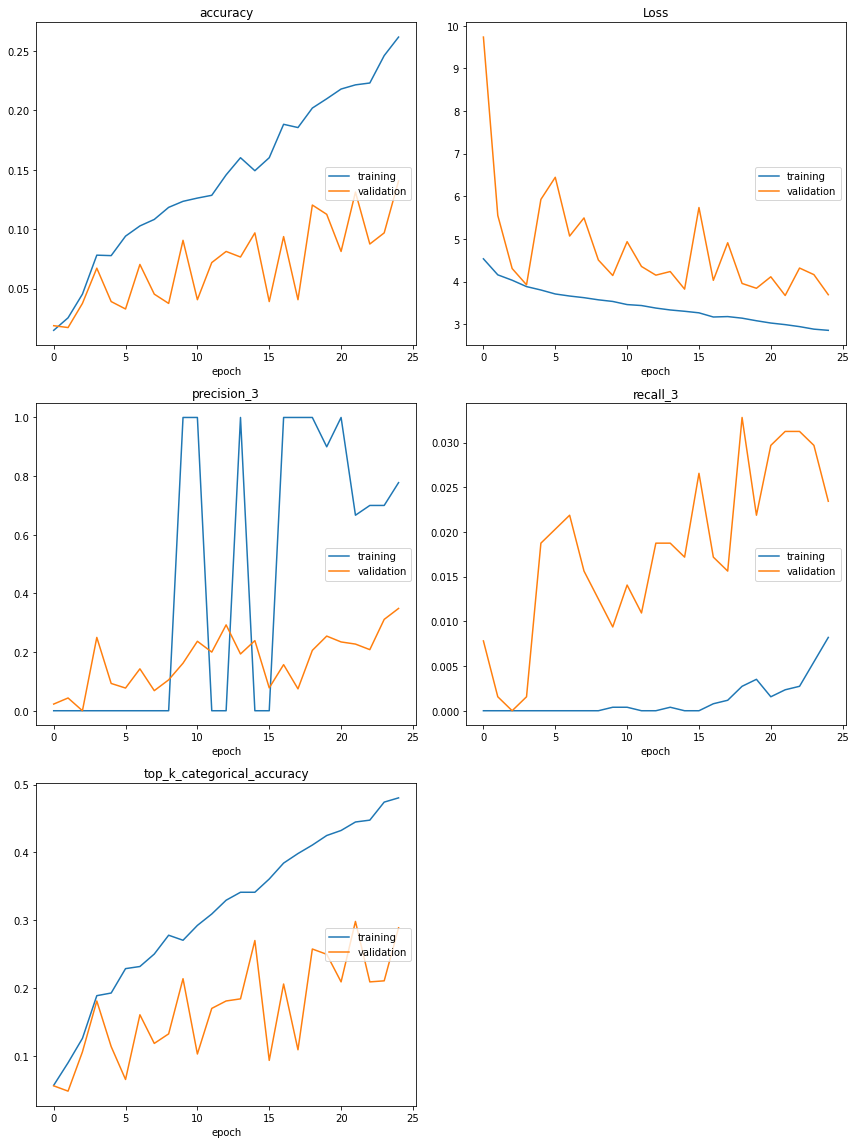

accuracy
	training         	 (min:    0.015, max:    0.262, cur:    0.262)
	validation       	 (min:    0.017, max:    0.141, cur:    0.141)
Loss
	training         	 (min:    2.855, max:    4.533, cur:    2.855)
	validation       	 (min:    3.672, max:    9.737, cur:    3.691)
precision_3
	training         	 (min:    0.000, max:    1.000, cur:    0.778)
	validation       	 (min:    0.000, max:    0.349, cur:    0.349)
recall_3
	training         	 (min:    0.000, max:    0.008, cur:    0.008)
	validation       	 (min:    0.000, max:    0.033, cur:    0.023)
top_k_categorical_accuracy
	training         	 (min:    0.057, max:    0.480, cur:    0.480)
	validation       	 (min:    0.048, max:    0.298, cur:    0.289)
Epoch 26/30
80/80 [==============================] - 45s 567ms/step - loss: 2.8376 - accuracy: 0.2637 - top_k_categorical_accuracy: 0.4965 - precision_3: 0.7419 - recall_3: 0.0090 - val_loss: 3.5962 - val_accuracy: 0.1625 - val_top_k_categorical_accuracy: 0.3172 - val_precision

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(80))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

AlexNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
               loss='categorical_crossentropy',
               metrics=['accuracy',
                        tf.keras.metrics.TopKCategoricalAccuracy(k=3),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall()
                        ])

history = AlexNet.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    steps_per_epoch=int(math.ceil(train_generator.n/train_generator.batch_size)),
    validation_steps=int(math.ceil(validation_generator.n/validation_generator.batch_size)),
    callbacks=[PlotLossesKeras()])

eval_loss, eval_accuracy, acc3, precision, recall = AlexNet.evaluate(validation_generator, verbose=1)
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))
print("k = 3 Accuracy: {:.2f}%".format(acc3 * 100)) 
print("Precision: {}".format(precision)) 
print("Recall: {}".format(recall))

### **Prediction results and performance metrics**

In [ ]:
eval_loss, eval_accuracy, acc3, precision, recall = AlexNet.evaluate(test_generator, batch_size=32)
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))
print("k = 3 Accuracy: {:.2f}%".format(acc3 * 100)) 
print("Precision: {}".format(precision)) 
print("Recall: {}".format(recall))

25/25 [==============================] - 8s 310ms/step - loss: 3.8865 - accuracy: 0.1363
test loss, test acc: [3.8865020275115967, 0.13625000417232513]


### **Save and retrieve model**

In [ ]:
AlexNet.save(projectDir + '/' + 'Models/AlexNetV1.h5')

In [ ]:
AlexNet = tf.keras.models.load_model(projectDir + '/' + 'Models/AlexNetV1.h5')
results = AlexNet.evaluate(test_generator, batch_size=32)
print("test loss, test acc:", results)

## **VGG-19**

In [ ]:
input_shape = (180, 180, 3)
learning_rate = 0.001
fine_tune = 1
dropout = 0.2
layer1 = 4096
layer2 = 1072

#Build data generators
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg19

train_datagen = ImageDataGenerator(
        preprocessing_function = vgg19.preprocess_input,
        rescale=1./255,
        shear_range=0.6,
        zoom_range=0.7,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(
    preprocessing_function = vgg19.preprocess_input,
    rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        trainDir,
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        validationDir,
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        testDir,
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical')

Found 2560 images belonging to 80 classes.
Found 640 images belonging to 80 classes.
Found 800 images belonging to 80 classes.


### **Compile and train model**

In [ ]:
vggModel = tf.keras.applications.VGG19(input_shape=input_shape,include_top=False,weights='imagenet')
if fine_tune > 0:
  for layer in vggModel.layers[:-fine_tune]: layer.trainable = False
else:
  for layer in vggModel.layers: layer.trainable = False


inputs = tf.keras.Input(shape=input_shape)
x = vggModel(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten(name="flatten")(x)
x = tf.keras.layers.Dense(layer1, activation='relu')(x)
x = tf.keras.layers.Dense(layer2, activation='relu')(x)
x = tf.keras.layers.Dropout(dropout)(x)
outputs = tf.keras.layers.Dense(80, activation='softmax')(x)

model4 = tf.keras.Model(inputs, outputs)

model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
               loss='categorical_crossentropy',
               metrics=['accuracy',
                        tf.keras.metrics.TopKCategoricalAccuracy(k=3),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall()
                        ])

history = model4.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    steps_per_epoch=int(math.ceil(train_generator.n/train_generator.batch_size)),
    validation_steps=int(math.ceil(validation_generator.n/validation_generator.batch_size)),
    callbacks=[PlotLossesKeras()])

eval_loss, eval_accuracy, acc3, precision, recall = model4.evaluate(validation_generator, verbose=1)
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))
print("k = 3 Accuracy: {:.2f}%".format(acc3 * 100)) 
print("Precision: {}".format(precision)) 
print("Recall: {}".format(recall))

Epoch 1/30
40/40 [==============================] - 52s 1s/step - loss: 4.4206 - accuracy: 0.0230 - val_loss: 4.2156 - val_accuracy: 0.0734
Epoch 2/30
40/40 [==============================] - 50s 1s/step - loss: 4.0535 - accuracy: 0.0539 - val_loss: 3.6617 - val_accuracy: 0.1047
Epoch 3/30
40/40 [==============================] - 50s 1s/step - loss: 3.7065 - accuracy: 0.0863 - val_loss: 3.3601 - val_accuracy: 0.1703
Epoch 4/30
40/40 [==============================] - 51s 1s/step - loss: 3.4498 - accuracy: 0.1184 - val_loss: 3.2031 - val_accuracy: 0.1844
Epoch 5/30
40/40 [==============================] - 51s 1s/step - loss: 3.2772 - accuracy: 0.1445 - val_loss: 3.0706 - val_accuracy: 0.2000
Epoch 6/30
40/40 [==============================] - 50s 1s/step - loss: 3.1375 - accuracy: 0.1781 - val_loss: 2.9713 - val_accuracy: 0.2141
Epoch 7/30
40/40 [==============================] - 50s 1s/step - loss: 3.0754 - accuracy: 0.1875 - val_loss: 2.8812 - val_accuracy: 0.2422
Epoch 8/30
40/40 [==

### **Prediction results and performance metrics**

In [ ]:
eval_loss, eval_accuracy, acc3, precision, recall = model4.evaluate(test_generator, batch_size=32)
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))
print("k = 3 Accuracy: {:.2f}%".format(acc3 * 100)) 
print("Precision: {}".format(precision)) 
print("Recall: {}".format(recall))

13/13 [==============================] - 8s 611ms/step - loss: 2.5212 - accuracy: 0.3613
test loss, test acc: [2.521210193634033, 0.36125001311302185]


### **Save and retrieve model**

In [ ]:
model4.save(projectDir + '/' + 'Models/RNModelV1.h5')

In [ ]:
model4 = tf.keras.models.load_model(projectDir + '/' + 'Models/RNModelV1.h5')
results = model4.evaluate(test_generator, batch_size=32)
print("test loss, test acc:", results)

# **Selecting and playing with best model**

In [8]:
best_model = tf.keras.models.load_model(projectDir + '/' + 'Models/VGG16ModelV7.h5')

Let us actually verify the accuracy of this model on the test set by printing the ground truth versus prediction for each image in the test set. Note that shuffle=False in the generator because otherwise it's difficult to extract the ground truth labels in the order that the generator shuffled the images. It really doesn't matter if we don't shuffle here, since we aren't training.

In [66]:
test_datagen = ImageDataGenerator(
    preprocessing_function = vgg16.preprocess_input,
    rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    testDir,
    target_size=(240, 240),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)
results = best_model.evaluate(test_generator)
print(results)

Found 800 images belonging to 80 classes.
13/13 [==============================] - 238s 18s/step - loss: 2.5766 - accuracy: 0.5138
[2.576601982116699, 0.5137500166893005]


In [67]:
y_prob = best_model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=-1)
y_test = test_generator.labels
for i in range(len(y_pred)):
  print(f"Truth: {categories[y_test[i]]}, Prediction: {categories[y_pred[i]]}")

Truth: adhirasam, Prediction: adhirasam
Truth: adhirasam, Prediction: chak_hao_kheer
Truth: adhirasam, Prediction: adhirasam
Truth: adhirasam, Prediction: adhirasam
Truth: adhirasam, Prediction: poornalu
Truth: adhirasam, Prediction: kofta
Truth: adhirasam, Prediction: adhirasam
Truth: adhirasam, Prediction: adhirasam
Truth: adhirasam, Prediction: adhirasam
Truth: adhirasam, Prediction: adhirasam
Truth: aloo_gobi, Prediction: aloo_gobi
Truth: aloo_gobi, Prediction: aloo_gobi
Truth: aloo_gobi, Prediction: bhindi_masala
Truth: aloo_gobi, Prediction: aloo_gobi
Truth: aloo_gobi, Prediction: aloo_gobi
Truth: aloo_gobi, Prediction: aloo_gobi
Truth: aloo_gobi, Prediction: navrattan_korma
Truth: aloo_gobi, Prediction: aloo_gobi
Truth: aloo_gobi, Prediction: aloo_gobi
Truth: aloo_gobi, Prediction: aloo_gobi
Truth: aloo_matar, Prediction: aloo_matar
Truth: aloo_matar, Prediction: dal_tadka
Truth: aloo_matar, Prediction: dum_aloo
Truth: aloo_matar, Prediction: aloo_gobi
Truth: aloo_matar, Predict

It seems the predictions do seem to corroborate the 51% accuracy, and there are definitely some interesting patterns to be noted from these predictions. For example:

1. The model had a lot of trouble recognizing "aloo shimla mirch", getting only 1 prediction correct. But if you look at the other predictions, they are actually quite reasonable - it suggests other "aloo"/potato related dishes like "aloo matar," "dum aloo," or "aloo gobi". So clearly, the model has atleast been able to understand that this is some kind of a potato dish
2. The model seems to confuse "anarsa" and "ariselu" sometimes too, which is also reasonable because they are very similar looking foods
3. Butter chicken was very often confused with chicken tikka masala, also fair. Chicken tikka also confused with chicken tikka masala a couple of times
4. In the Indian sweet arena, the model sometimes mistakes imarti with jalebi and vice versa - they are also extremely similar looking foods!
5. It mistook naan for chapati once

There are probably some more very interesting patterns to the prediction behavior of this model (to be perfectly candid, I myself do not know about all of these foods), but nevertheless, this is quite reasssuring. A 50%+ accuracy on a model that needs to distinguish between 80 different classes is a pretty satisfactory performance in my opinion. It is still more often right than wrong, and given that a dumb model that randomly predicted would only be correct 1.25% of the time, 50% is a substantial improvement. 





Now, let's try setting up a pipeline for the model to make predictions on a random image (or set). Unfortunately, Keras doesn't make this all that much easier, since the model we compiled is inflexible in terms of how it accepts input. It requires rank 4 tensors since it was trained on batches, so any singular image needs to be converted to a rank 4 tensor before being fed to the model. Also, the preprocessing and resizing work seems to be far easier if the image data generator flows data out of a directory ...

In [90]:
generatorDir = os.path.join(projectDir, 'image')
os.mkdir(generatorDir)
imagePath = ""

In [96]:
def randomImage():
  global imagePath
  global generatorDir
  #Remove old image if it exists
  if pathlib.Path(imagePath).is_file():
    os.remove(imagePath)
    os.rmdir(os.path.dirname(imagePath))

  randomCategory = np.random.choice(categories, 1)[0]
  imageDir = os.path.join(generatorDir, randomCategory)
  os.mkdir(imageDir)
  randomInt = np.random.randint(10)
  imagePath = f"{generatorDir}/{randomCategory}/image.jpg"
  imageio.imwrite(imagePath, imageio.imread(f"{testDir}/{randomCategory}/image{randomInt}.jpg"))
  image_datagen = ImageDataGenerator(
    preprocessing_function = vgg16.preprocess_input,
    rescale=1./255)
  image_generator = image_datagen.flow_from_directory(
    generatorDir,
    target_size=(240, 240),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
  )
  return imagePath, randomCategory, image_generator

Found 1 images belonging to 1 classes.
Truth: chicken_tikka, Prediction: chicken_tikka


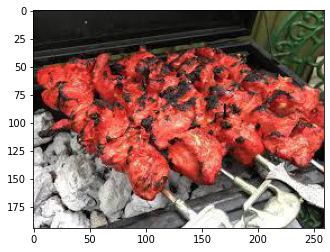

In [118]:
imagePath, category, image_generator = randomImage()
image = imageio.imread(imagePath)
prediction = best_model.predict(image_generator)
prediction = categories[prediction[0].argmax(axis=-1)]
print(f"Truth: {category}, Prediction: {prediction}")
plt.imshow(image)

So now we have something of a setup to run predictions on singular images - the code takes a random image (from the test set for now, but it could be from anywhere) and places it in a directory named after its class for the image data generator. Then, we can use our best model to predict on this generator that just generates a single image. 

# **Final notes**

Food classification is a fun task, but it was by no means easy. Dealing with 80 different classes definitely means the model requires a lot more fine-grained distinguishing power. Moreover, Indian food inherently poses its own challenges - the foods are usually quite complex in their appearance because of the vast set of ingredients used. Moreover, classifying food can be challenging because it doesn't take a lot for similar dishes, both in terms of appearance and ingredients, to be treated differently. Expecting a model to be able to discern those very subtle differences is nontrivial. Frankly, even a human may have trouble spotting those differences just by looking at the image. 

That being said, this project really does exemplify the power of CNNs - although some of the architectures performed poorly, VGG-16 really rose to the occasion and brought us past a 50% accuracy. However, I'm sure there is room for improvement, whether its more aggressive fine-tuning, or other models itself. Maybe a gradient boosting framework might do well, or other computer vision models like vision transformers, etc. Exciting to think about the avenues out there to make these models even more powerful!